# Random Forest / Boosting

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

# 시각화
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
path = 'data/'

def load_data(name) :
    data = pd.read_csv(path + name + '.csv')
    data = data.drop(columns='Unnamed: 0')
    return data

x_train = load_data('x_train')
x_test = load_data('x_test')
y_train = load_data('y_train')
y_test = load_data('y_test')

In [3]:
x_train.head()

,Gender,customer_type,type_of_travel,customer_class,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,...,onboard_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,age,flight_distance,departure_delay_in_minutes,arrival_delay_in_minutes
0,1,0,1,1,1,5,1,3,1,1,...,1,2,4,1,5,1,49,954,0,0.0
1,0,0,0,0,4,4,4,4,3,5,...,4,4,4,3,4,4,44,3549,0,0.0
2,1,1,0,1,5,0,5,2,2,5,...,5,3,5,3,4,2,22,650,39,36.0
3,1,1,0,0,1,0,1,5,5,1,...,3,4,5,3,5,5,26,429,0,0.0
4,0,1,0,1,1,1,1,2,2,1,...,3,5,2,4,3,2,24,852,29,20.0


## 함수 선언

In [4]:
def con_matrix(model, y_test, y_pred):

    # 분류정확도 평가 지표
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    # confusion matrix 
    con_mat = confusion_matrix(y_true=y_test, y_pred=y_pred) 
    
    # confusion matrix heatmap  
    plt.figure(figsize=(6,6))
    sn.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, cmap = 'Blues_r', square = True)
    plt.ylabel('Actual label'); 
    plt.xlabel('Predicted label'); 
    all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy) 
    plt.title(all_sample_title, size = 14) 
    plt.show()
    
    print('Precision:{:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [5]:
# 특성 중요도 시각화
def plot_feature_importances(model):
    n_features = x_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), x_train.columns)
    plt.xlabel("feature importances")
    plt.ylabel("features")
    plt.ylim(-1, n_features)
    plt.show()

In [6]:
# 랜덤 포레스트 학습 및 예측
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(x_train, y_train)
pred = rf_clf.predict(x_test)

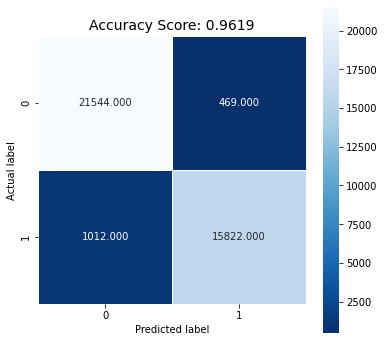

Precision:0.9712
Recall: 0.9399
F1: 0.9553
AUC: 0.9593


In [7]:
con_matrix(rf_clf, y_test, pred)

## 하이퍼 파라미터 튜닝 -> 과적합 해결

In [8]:
# RandomForest의 하이퍼 파라미터 default 상태
model = RandomForestClassifier()
model

RandomForestClassifier()

In [9]:
#GridSearchCV
#하이퍼 파라미터 별로 리스트 입력 -> 각 예측 성능 비교 -> 최적의 파라미터 도출
'''
max_depth = 트리 최대 깊이(default=None
              ~완벽하게 클래스 값이 결정될 때까지/데이터 수가 min_samples_split보다 작아질때까지 분할함)
max_features = 최적의 분할을 위해 고려할 최대 feature 개수(deafult='auto' != 의사결정나무는 'None')
n_estimators = 결정트리의 갯수
'''

from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [5, 10, 15, 20, 25], #default=10
           'max_depth' : [4, 8, 12],
           'min_samples_leaf' : [4, 8, 12, 18], #노드를 분할하기 위한 최소한의 샘플 데이터 수
           'min_samples_split' : [4, 8, 16, 20] #리프노드가 되기 위한 최소한의 샘플 데이터 수
            }

#GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 25}
최고 예측 정확도: 0.9500


In [10]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
rf1 = RandomForestClassifier(n_estimators = 25, 
                                max_depth = 12,
                                min_samples_leaf = 4,
                                min_samples_split = 4,
                                random_state = 0,
                                n_jobs = -1)
rf1.fit(x_train, y_train)
y_pred = rf1.predict(x_test)

In [11]:
print("Train_Accuracy : ", rf1.score(x_train, y_train))
print("Test_Accuracy : ", rf1.score(x_test, y_test))

Train_Accuracy :  0.9577780229479259
Test_Accuracy :  0.9514505624629959


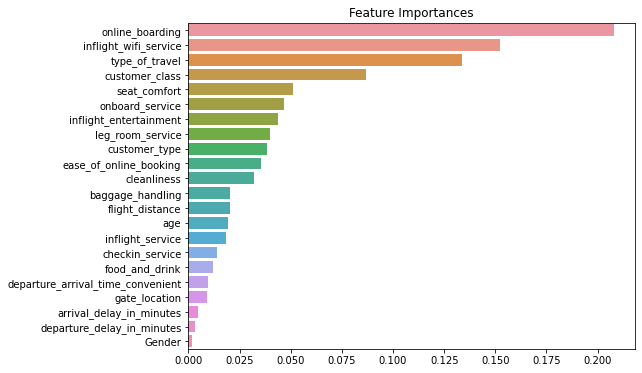

In [12]:
ftr_importances_values = rf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:22]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

특성 중요도 : 
[0.00168413 0.03816314 0.13353883 0.08669487 0.15245796 0.00935085
 0.03524898 0.00923311 0.01186686 0.20780227 0.05133498 0.04353517
 0.04670716 0.03964042 0.0205409  0.01375313 0.018556   0.03196209
 0.0192922  0.02047569 0.00340706 0.00475422]


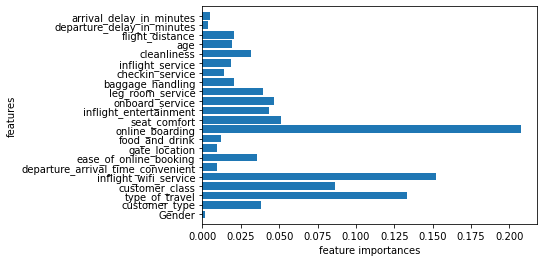

In [13]:
# 특성 중요도
print("특성 중요도 : \n{}".format(rf1.feature_importances_))
plot_feature_importances(rf1)

# Boosting

## Adaboost

In [14]:
clf = AdaBoostClassifier(random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

Train_Accuracy :  0.9269196822594881
Test_Accuracy :  0.9260174530851804


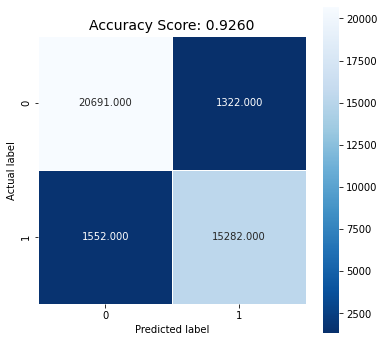

Precision:0.9204
Recall: 0.9078
F1: 0.9140
AUC: 0.9239


In [15]:
print("Train_Accuracy : ", clf.score(x_train, y_train))
print("Test_Accuracy : ", clf.score(x_test, y_test))
con_matrix(clf, y_test, y_pred)

In [16]:
params = { 'n_estimators' : [25, 50, 100], #생성할 약한 학습기의 개수 #default=50
           'learning_rate':[0.5, 1.0] #학습을 진행할 때마다 적용하는 학습률
            }

clf_new = AdaBoostClassifier(random_state = 0)
grid_cv = GridSearchCV(clf_new, param_grid = params, cv = 3)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'learning_rate': 1.0, 'n_estimators': 100}
최고 예측 정확도: 0.9293


In [17]:
clf1 = RandomForestClassifier(n_estimators = 100, random_state = 0)
clf1.fit(x_train, y_train)
y_pred = clf1.predict(x_test)

Train_Accuracy :  0.9999889673433363
Test_Accuracy :  0.961876077946817


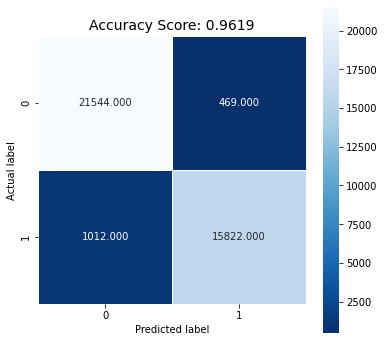

Precision:0.9712
Recall: 0.9399
F1: 0.9553
AUC: 0.9593


In [18]:
print("Train_Accuracy : ", clf1.score(x_train, y_train))
print("Test_Accuracy : ", clf1.score(x_test, y_test))
con_matrix(clf1, y_test, y_pred)

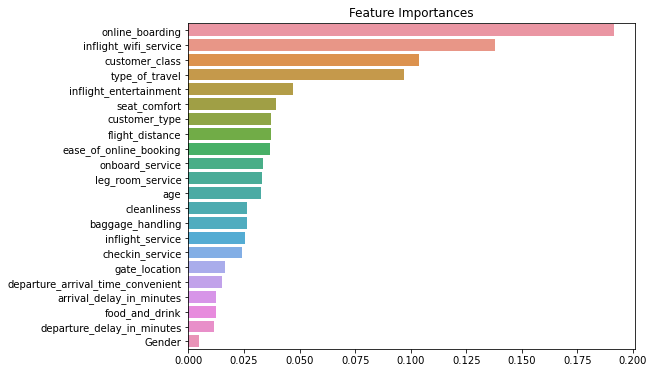

In [19]:
ftr_importances_values = clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:22]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

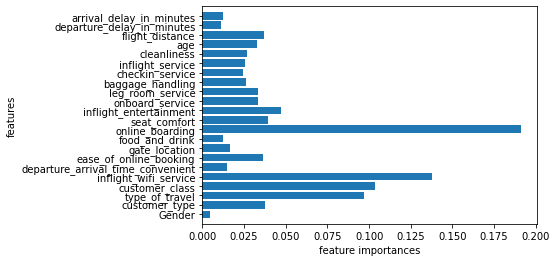

In [20]:
plot_feature_importances(clf1)

## GBM(Gradient Boost Machine)

In [21]:
#가중치 업데이트를 경사하강법(gradient descent) 이용
#예측 성능은 높음 but Greedy Algorithm -> 과적합 위험, 시간 오래 걸림

In [22]:
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(x_train, y_train.values)
gb_pred = gb_clf.predict(x_test)

Train_Accuracy :  0.9423323036187113
Test_Accuracy :  0.9422091796020284


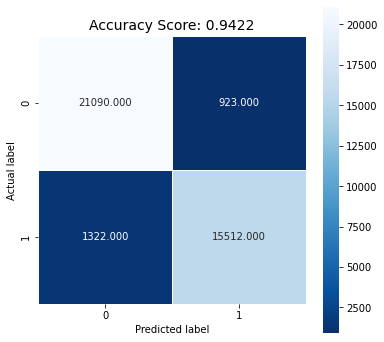

Precision:0.9438
Recall: 0.9215
F1: 0.9325
AUC: 0.9398


In [23]:
print("Train_Accuracy : ", gb_clf.score(x_train, y_train))
print("Test_Accuracy : ", gb_clf.score(x_test, y_test))
con_matrix(gb_clf, y_test, gb_pred)

In [24]:
#하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

param = {
    'n_estimators' : [50, 100, 150], #default=100
    'learning_rate' : [0.01, 0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid=param, cv=2, verbose=1, n_jobs=-1)
grid_cv.fit(x_train, y_train.values)
print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
최적 하이퍼 파라미터: 
 {'learning_rate': 0.1, 'n_estimators': 150}
최고 예측 정확도: 0.9477


In [25]:
gb_new = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,random_state=0)
gb_new.fit(x_train, y_train.values)
gb_pred = gb_new.predict(x_test)

Train_Accuracy :  0.9483671668137688
Test_Accuracy :  0.9472803562694674


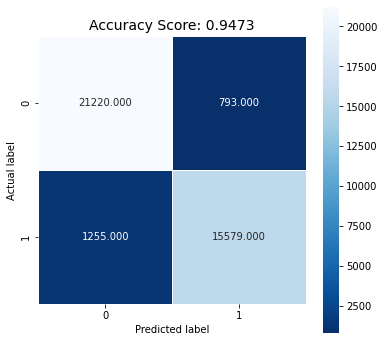

Precision:0.9516
Recall: 0.9254
F1: 0.9383
AUC: 0.9447


In [26]:
print("Train_Accuracy : ", gb_new.score(x_train, y_train))
print("Test_Accuracy : ", gb_new.score(x_test, y_test))
con_matrix(gb_new, y_test, gb_pred)

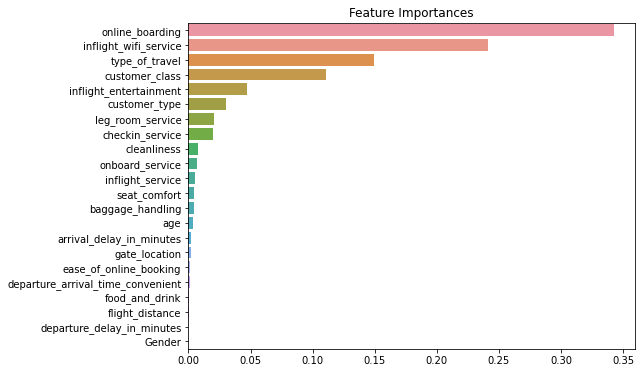

In [27]:
ftr_importances_values = gb_new.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:22]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## Xgb

예측 성능 G / 수행 시간 짧음 / 과적합 규제 / tree pruning / 자체 내장된 교차 검증 & 결손값 처리

In [28]:
# 모델 생성
xgb = XGBClassifier()
xgb.fit(x_train, y_train) 

# 모델 예측
xgb_pred = xgb.predict(x_test)

[22:10:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Train_Accuracy :  0.975684024713151
Test_Accuracy :  0.9631116945967514


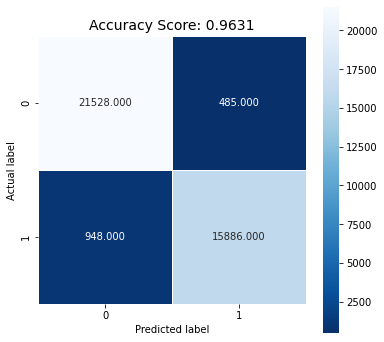

Precision:0.9704
Recall: 0.9437
F1: 0.9568
AUC: 0.9608


In [29]:
print("Train_Accuracy : ", xgb.score(x_train, y_train))
print("Test_Accuracy : ", xgb.score(x_test, y_test))
con_matrix(xgb, y_test, xgb_pred)

In [30]:
param = {
    'n_estimators':[50,100,150],
    'learning_rate':[0.01,0.05,0.1],
    'max_depth':[4,8,12,16]
}
grid_cv = GridSearchCV(xgb, param_grid=param, cv=2, verbose=1, n_jobs=-1)
grid_cv.fit(x_train, y_train.values)
print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[22:15:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
최적 하이퍼 파라미터: 
 {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 100}
최고 예측 정확도: 0.9620


In [36]:
xgb_new = XGBClassifier(learning_rate=0.1,max_depth=12,n_estimators=100)
xgb_new.fit(x_train, y_train) 
xgb_new_pred = xgb_new.predict(x_test)

[22:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Train_Accuracy :  0.9905339805825243
Test_Accuracy :  0.9631116945967514


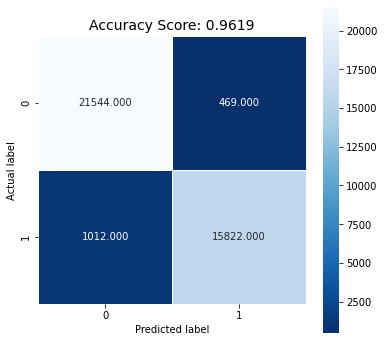

Precision:0.9712
Recall: 0.9399
F1: 0.9553
AUC: 0.9593


In [32]:
print("Train_Accuracy : ", xgb_new.score(x_train, y_train))
print("Test_Accuracy : ", xgb_new.score(x_test, y_test))
con_matrix(xgb_new, y_test, xgb_new_pred)

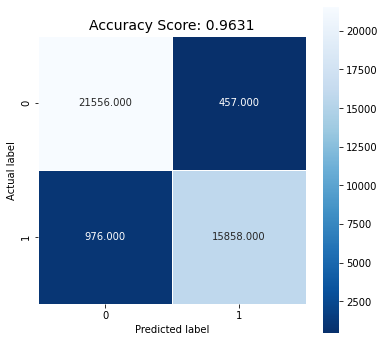

In [33]:
con_mat = confusion_matrix(y_test, xgb_new_pred)
acc = accuracy_score(y_test, xgb_new_pred)
plt.figure(figsize=(6,6))
sn.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5,
           cmap='Blues_r',square = True)
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Accuracy Score: {:.4f}'.format(acc) 
plt.title(all_sample_title, size = 14) 
plt.show()

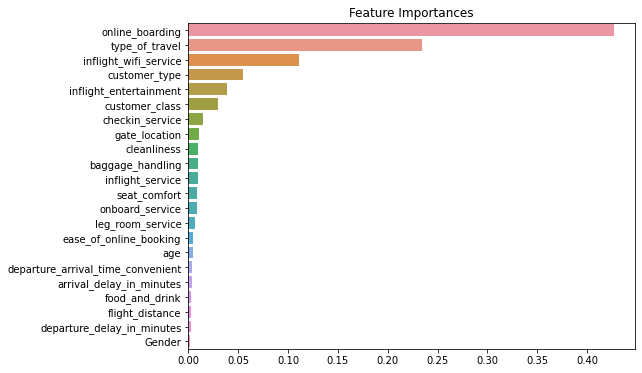

In [34]:
ftr_importances_values = xgb_new.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:22]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

특성 중요도 : 
[0.0019637  0.05439835 0.23451366 0.03001288 0.11085346 0.00357625
 0.00472735 0.01108376 0.00277737 0.42656258 0.00891633 0.03900763
 0.00884697 0.0070274  0.00938088 0.01470958 0.009127   0.00996245
 0.00434933 0.00254195 0.00213651 0.00352466]


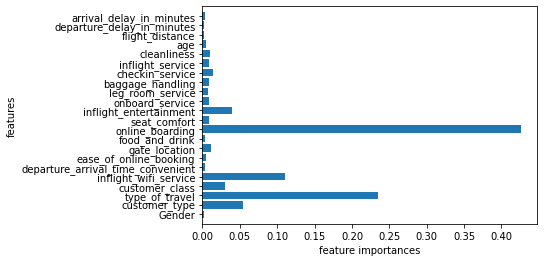

In [35]:
# 특성 중요도
print("특성 중요도 : \n{}".format(xgb_new.feature_importances_))
plot_feature_importances(xgb_new)